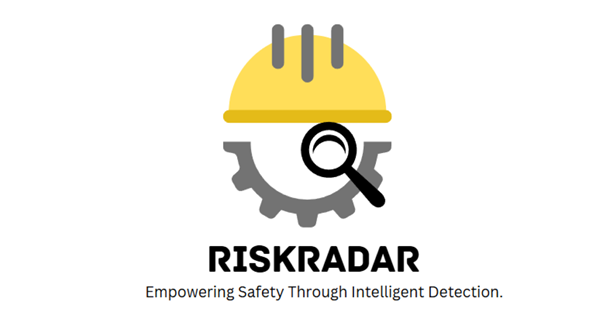


# **RiskRadar**

## Motivation


---

Construction sites are among the most hazardous work environments, with a significant risk of accidents
and injuries due to falling objects, machinery, and other dangers. Ensuring that workers adhere to safety
protocols by wearing appropriate Personal Protective Equipment (PPE) such as helmets, gloves, safety
vests, and goggles is crucial for mitigating these risks. However, traditional methods of monitoring PPE
compliance often rely on manual inspections, which can be inconsistent and labor-intensive. There is a
pressing need for automated systems that can efficiently and accurately monitor PPE usage in real time to
enhance safety and ensure regulatory compliance.

The goal of this project is to develop an automated system that can identify whether employees are
wearing the necessary safety gear, such as hardhat and vests, gloves, mask ,by analyzing images taken at
the workplace. The system will use deep learning models for object detection and machine learning
classifiers to ensure compliance with safety regulations.  

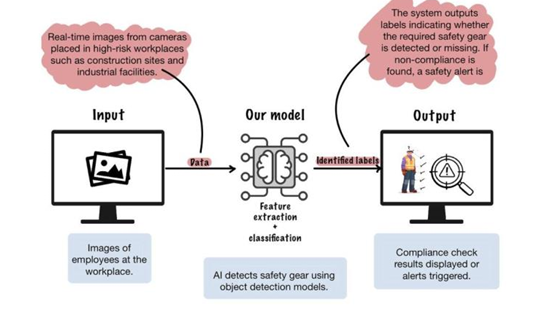

## Installing and importing dependencies 📚

----

We'll import the following libraries for EDA, visualizations, feature extraction with SVM, and YOLOv8X:

-Basic Operations and Data Handling:

- os and glob: For accessing and navigating file directories.

- numpy: For array operations.

- pandas: For working with dataframes and creating metadata.

-Image Processing and Visualizations:

- PIL (from PIL import Image): For handling image operations.

- cv2: OpenCV library for image operations and visualization.

- matplotlib.pyplot: For plotting results and visualizations of class distributions.

-Feature Extraction with HOG and SVM:

- skimage.feature.hog: For extracting HOG (Histogram of Oriented Gradients) features, which will be used as input to the SVM classifier.

- sklearn.model_selection.train_test_split: For splitting data into training and test sets.

- sklearn.svm.SVC: For training an SVM classifier.

- sklearn.metrics.accuracy_score and classification_report: For evaluating the SVM model performance.

-Object Detection with YOLOv8X:

- ultralytics.YOLO: For training and evaluating the YOLOv8X object detection model.


In [4]:
!pip install ultralytics --upgrade
!pip install -U ipywidgets
!pip install ffmpeg-python
!pip install roboflow
!wandb disabled


W&B disabled.


In [5]:
from ultralytics import YOLO
import os
import glob
from pathlib import Path
from roboflow import Roboflow
import matplotlib.pyplot as plt
import numpy as np
import yaml
import torch
import cv2
import random
import seaborn as sns
import pandas as pd
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
from PIL import Image
from IPython.display import HTML, display, Image
from base64 import b64encode
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

np.random.seed(12345)
%matplotlib inline


### Roboflow Dataset Integration

In [6]:
rf = Roboflow(api_key="XbLHspFnwkXyuxgTOeVJ")
project = rf.workspace("roboflow-universe-projects").project("construction-site-safety")
version = project.version(28)
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...


### Define Paths and Parameters

In [7]:
dataset_path = dataset.location
INPUT_DIR =dataset_path
WORK_DIR = '/content/RiakRadar/'
os.makedirs(WORK_DIR, exist_ok=True)

In [8]:
# Number of classes and their names
num_classes = 10
classes = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']

# Exploratory Data Analysis (EDA)
We will first do an exploratory data analysis on the CSS Dataset and try to see the distribution of train, valid and test sets. We will also visualize the samples, and run a custom object detection model to detect one of the following PPE classes:

['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']

In [6]:
# Count Images
dataset_path = dataset.location
for subset_folder in ['train', 'valid', 'test']:
    subset_images = glob.glob(os.path.join(dataset_path, subset_folder, 'images','*.jpg'))
    print(f"Number of {subset_folder} images:", len(subset_images))


Number of train images: 2605
Number of valid images: 114
Number of test images: 82


In [9]:
# Create Dataset YAML
dict_file = {'train': os.path.join(INPUT_DIR, 'train'),
             'val': os.path.join(INPUT_DIR, 'valid'),
             'test': os.path.join(INPUT_DIR, 'test'),
             'nc': num_classes,
             'names': classes
            }

with open(os.path.join(WORK_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)


In [8]:
# Calculate Class Distribution
class_idx = {str(i):classes[i] for i in range(num_classes)}

class_stat = {}
data_len = {}

for mode in ['train', 'valid', 'test']:

    class_count = {classes[i]:0 for i in range(num_classes)}

    path = os.path.join(INPUT_DIR, mode, 'labels')

    for file in os.listdir(path):

        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

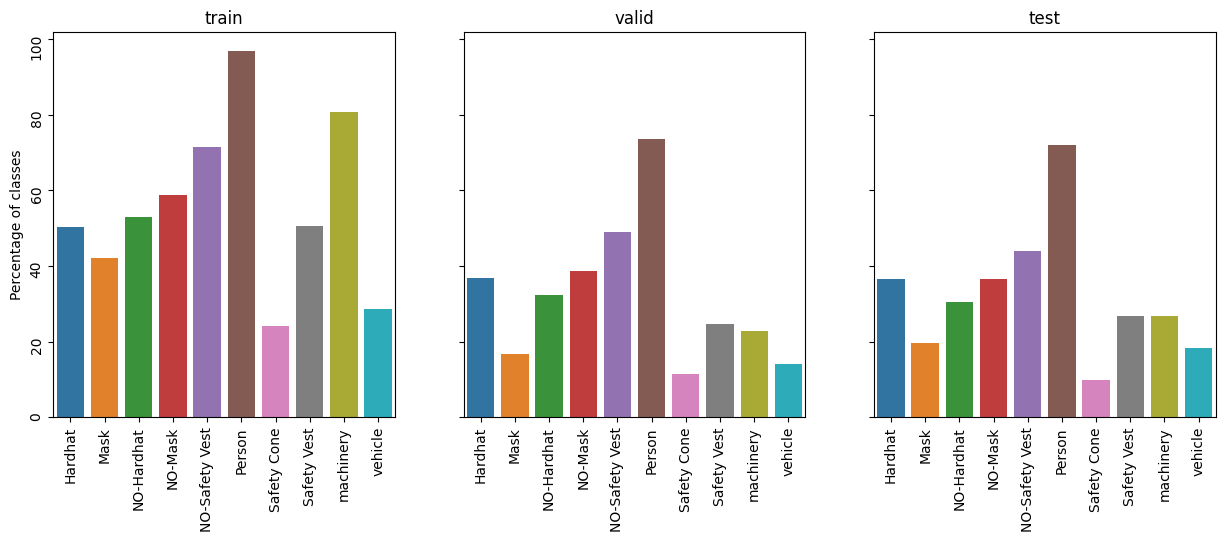

In [9]:
# Visualize Class Distribution

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(pd.DataFrame({mode: class_stat[mode]}).T / data_len[mode] * 100, ax=ax[i])
    ax[i].set_title(mode)
    ax[i].tick_params(rotation=90)
    ax[i].set_ylabel('Percentage of classes')
plt.show()


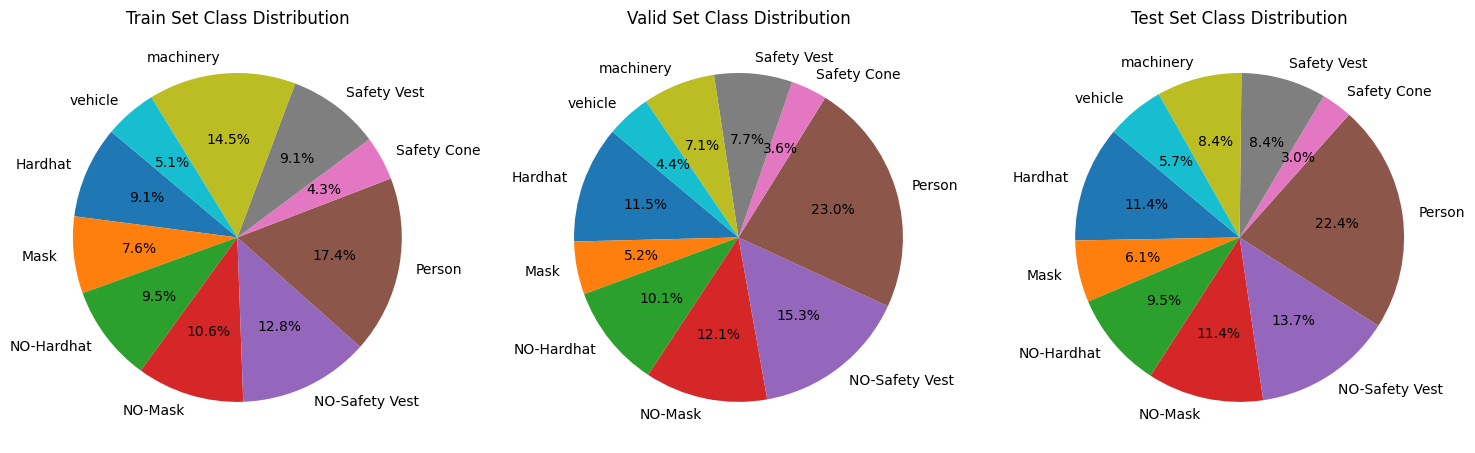

In [10]:
# Visualize Class Distribution with Pie Charts

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, mode in enumerate(['train', 'valid', 'test']):
    class_counts = list(class_stat[mode].values())
    class_labels = list(class_stat[mode].keys())
    ax[i].pie(class_counts, labels=class_labels, autopct='%1.1f%%', startangle=140)
    ax[i].set_title(f'{mode.capitalize()} Set Class Distribution')

plt.tight_layout()
plt.show()


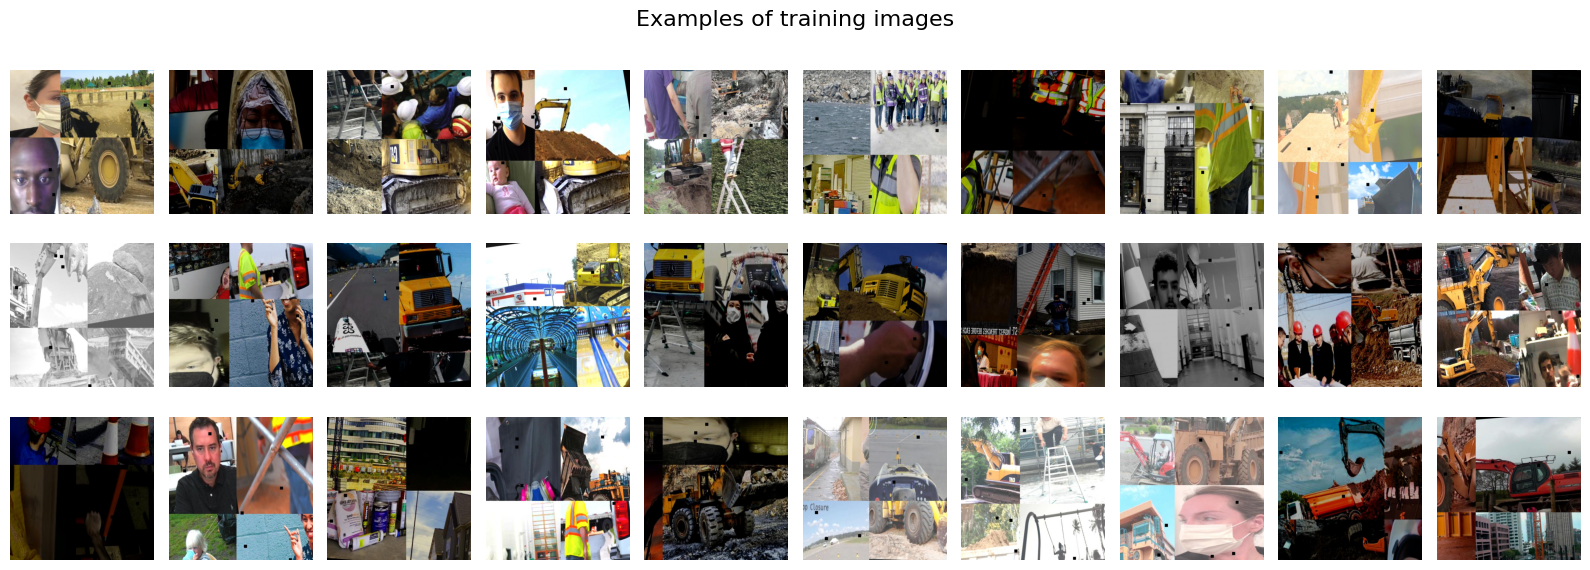

In [11]:
# Display Sample Training Images

test_imgs_with_pred = glob.glob(os.path.join(INPUT_DIR, 'train', 'images','*.jpg'))

fig, axes = plt.subplots(3, 10, figsize=(16,6))
fig.suptitle('Examples of training images', fontsize=16)


# Randomly select 15 images
selected_images = random.sample(test_imgs_with_pred, 30)

for i, ax in enumerate(axes.flatten()):
    image = cv2.imread(selected_images[i])
    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ax.imshow(image)
    ax.axis("off")

plt.tight_layout()
plt.show()


We can notice that there are some tiny black rectangles on most of the training images and this is because one of the augmentation techniques used for this dataset is random crop between 0 and 20% for each image


#   SVM as a baseline model:

 1-Prepare Data for SVM: Extract features from images using HOG .

 2-Train SVM: Use labeled data to train the SVM classifier.

 3-Evaluate SVM: Measure accuracy and classification metrics

In [12]:

# Define HOG parameters
hog_params = {
    "orientations": 9,
    "pixels_per_cell": (8, 8),
    "cells_per_block": (2, 2),
    "block_norm": 'L2-Hys'
}

# Prepare data for SVM
X, y = [], []
for mode in ['train', 'valid', 'test']:
    print(f"\nProcessing {mode} set...")  # Debug: Show current mode
    image_files = glob.glob(os.path.join(INPUT_DIR, mode, 'images', '*.jpg'))
    label_files = glob.glob(os.path.join(INPUT_DIR, mode, 'labels', '*.txt'))

    print(f"Found {len(image_files)} images and {len(label_files)} label files in {mode} set.")

    for image_file in image_files:
        # Load and check image
        image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Image not found or unable to load: {image_file}")
            continue
        else:
            print(f"Loaded image: {image_file}")  # Debug

        # Extract HOG features
        hog_features = hog(image, **hog_params)

        # Corresponding label file
        label_file = image_file.replace('images', 'labels').replace('.jpg', '.txt')
        if not os.path.exists(label_file):
            print(f"No label file found for image: {image_file}")
            continue

        with open(label_file, 'r') as f:
            lines = f.readlines()
            found_valid_line = False
            for line in lines:
                stripped_line = line.strip()
                if stripped_line:
                    parts = stripped_line.split()
                    if len(parts) > 0:
                        class_id = int(parts[0])
                        X.append(hog_features)  # Only add HOG features if label is valid
                        y.append(class_id)
                        found_valid_line = True
                        print(f"Appended HOG features and label for image: {image_file}, class ID: {class_id}")
                        break  # Stop after finding the first valid line

            if not found_valid_line:
                print(f"Warning: No valid lines in label file {label_file}")

# Final debug checks
print(f"\nTotal features (X): {len(X)}, Total labels (y): {len(y)}")
if len(X) != len(y):
    print("Warning: Mismatch in number of features and labels")

# Only proceed if we have data to split
if len(X) > 0 and len(y) > 0:
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Debug: Show final dataset split sizes
    print(f"Training set size: {len(X_train)} samples")
    print(f"Test set size: {len(X_test)} samples")
else:
    print("Error: No data available for training and testing. Please check the dataset.")


Streaming output truncated to the last 5000 lines.
Loaded image: /content/Construction-Site-Safety-28/train/images/airport_inside_0363_jpg.rf.0c8e1d8f49a8f7f8fa0fd1be8019db94.jpg
Appended HOG features and label for image: /content/Construction-Site-Safety-28/train/images/airport_inside_0363_jpg.rf.0c8e1d8f49a8f7f8fa0fd1be8019db94.jpg, class ID: 3
Loaded image: /content/Construction-Site-Safety-28/train/images/construction-212-_jpg.rf.0f02bc1536288f419c6d04b5f81ce251.jpg
Appended HOG features and label for image: /content/Construction-Site-Safety-28/train/images/construction-212-_jpg.rf.0f02bc1536288f419c6d04b5f81ce251.jpg, class ID: 8
Loaded image: /content/Construction-Site-Safety-28/train/images/006012_jpg.rf.eb12c4a250f91e1f6efb9781b2c78604.jpg
Appended HOG features and label for image: /content/Construction-Site-Safety-28/train/images/006012_jpg.rf.eb12c4a250f91e1f6efb9781b2c78604.jpg, class ID: 2
Loaded image: /content/Construction-Site-Safety-28/train/images/construction-855-_jpg

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the SVM model with a balanced class weight to handle class imbalance
svm_model = SVC(kernel='rbf', class_weight='balanced')

# Train the SVM model
svm_model.fit(X_train, y_train)
print("SVM training complete.")

NameError: name 'X' is not defined

In [2]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the test set
y_pred = svm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy}")

# Print detailed classification metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=1))


NameError: name 'svm_model' is not defined

# Step 7: Train YOLO11n Model


---


The plan is to initially train the YOLO model without any hyperparameter tuning to establish a performance baseline. This approach allows us to evaluate the model’s default capabilities. Following this, we’ll conduct a systematic hyperparameter tuning process using grid search, focusing on optimizing key parameters such as learning rate, number of epochs, and batch size. This two-step process ensures we understand the base performance first, then explore improvements through careful parameter adjustments to enhance detection accuracy.


---



`epochs=10` : providing a basic benchmark without overfitting.

`batch=32` : A batch size of 32 is a reasonable choice, balancing memory usage and model update frequency.

In [10]:
from ultralytics import YOLO

# Load YOLO model
model = YOLO("yolo11n.pt")

# Train YOLO model with specified parameters
model.train(
    data=os.path.join(WORK_DIR, 'data.yaml'),
    epochs=10,
    batch=32,
    imgsz=640
)


Ultralytics 8.3.23 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/RiakRadar/data.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

100%|██████████| 755k/755k [00:00<00:00, 20.9MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /content/Construction-Site-Safety-28/train/labels... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:04<00:00, 580.93it/s]

train: WARNING ⚠️ /content/Construction-Site-Safety-28/train/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/Construction-Site-Safety-28/train/images/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed


train: New cache created: /content/Construction-Site-Safety-28/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /content/Construction-Site-Safety-28/valid/labels... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<00:00, 398.95it/s]

val: New cache created: /content/Construction-Site-Safety-28/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      7.73G      1.431      3.278      1.496        160        640: 100%|██████████| 82/82 [00:56<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.62s/it]

                   all        114        697      0.713      0.216      0.285       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      5.49G       1.39          2       1.46        171        640: 100%|██████████| 82/82 [00:46<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all        114        697       0.56      0.425      0.427      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      5.82G      1.324      1.726      1.427        177        640: 100%|██████████| 82/82 [00:48<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all        114        697      0.597      0.429      0.465      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      6.16G      1.304      1.606      1.401        216        640: 100%|██████████| 82/82 [00:48<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all        114        697      0.638      0.396      0.464      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      6.51G       1.26      1.485      1.363        124        640: 100%|██████████| 82/82 [00:45<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]

                   all        114        697      0.658       0.52      0.548      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      5.71G      1.209      1.361      1.332        193        640: 100%|██████████| 82/82 [00:45<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all        114        697      0.717      0.516      0.595      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      6.79G      1.171      1.278      1.311        127        640: 100%|██████████| 82/82 [00:48<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all        114        697       0.74      0.579      0.634      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      6.01G      1.139      1.208      1.282        198        640: 100%|██████████| 82/82 [00:47<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]

                   all        114        697      0.769      0.597      0.655      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      5.58G      1.094      1.142      1.254        135        640: 100%|██████████| 82/82 [00:45<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]

                   all        114        697      0.823      0.598      0.677      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      6.23G      1.064      1.087       1.23        173        640: 100%|██████████| 82/82 [00:45<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all        114        697      0.845      0.606      0.687      0.364



10 epochs completed in 0.142 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.23 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,584,102 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


                   all        114        697      0.845      0.606      0.688      0.364
               Hardhat         42         79      0.928      0.734      0.832      0.488
                  Mask         19         21      0.973       0.81      0.817      0.462
            NO-Hardhat         37         69      0.882      0.478      0.562      0.254
               NO-Mask         44         74      0.901      0.371      0.494        0.2
        NO-Safety Vest         56        106      0.766      0.509      0.579      0.288
                Person         84        166      0.794      0.699      0.769      0.386
           Safety Cone         13         44      0.801      0.682       0.73      0.345
           Safety Vest         28         41          1      0.626      0.828       0.42
             machinery         26         55      0.789      0.746      0.822      0.513
               vehicle         16         42      0.616      0.405      0.442       0.28
Speed: 0.2ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c106f7a60b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

# Evaluation of Yolo11 model


---



In [11]:
# Evaluate YOLOv8X model
metrics = model.val()
print("YOLOv8X Evaluation Metrics:", metrics)


Ultralytics 8.3.23 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,584,102 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /content/Construction-Site-Safety-28/valid/labels.cache... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


                   all        114        697      0.847       0.61      0.689      0.365
               Hardhat         42         79      0.942      0.734      0.834      0.489
                  Mask         19         21      0.971       0.81      0.817      0.462
            NO-Hardhat         37         69       0.88      0.478      0.565      0.254
               NO-Mask         44         74      0.891      0.378      0.496      0.198
        NO-Safety Vest         56        106      0.759      0.509       0.58      0.288
                Person         84        166      0.792      0.699      0.769      0.386
           Safety Cone         13         44      0.795      0.682       0.73      0.354
           Safety Vest         28         41          1       0.63      0.829       0.42
             machinery         26         55      0.789       0.75      0.822      0.513
               vehicle         16         42      0.649      0.429       0.45      0.282
Speed: 0.3ms preproce

**Precision (B): 0.84 (84.49%)**:
The model has a high precision rate, indicating that when it predicts a safety item/person, it's correct 84.49% of the time


---
**Recall (B): 0.61 (60.59%)**:
The model detects 60.59% of all safety items/persons present.it shows moderate performance in detecting all relevant objects.We could further enhance the model's performance by training for more epochs

---
**mAP50 (B): 0.69 (68.75%)**:
Good overall detection accuracy when using a 50% overlap criterion

---
**mAP50-95 (B): 0.36 (36.36%)**:
This lower score across varying IoU thresholds suggests that while the model performs well at lower thresholds, its performance drops with stricter evaluation criteria, indicating potential issues with detection accuracy.


---
Fitness Score: 0.40 (39.60%):
his overall fitness score reflects a balance of precision, recall, and mAP, suggesting moderate performance.




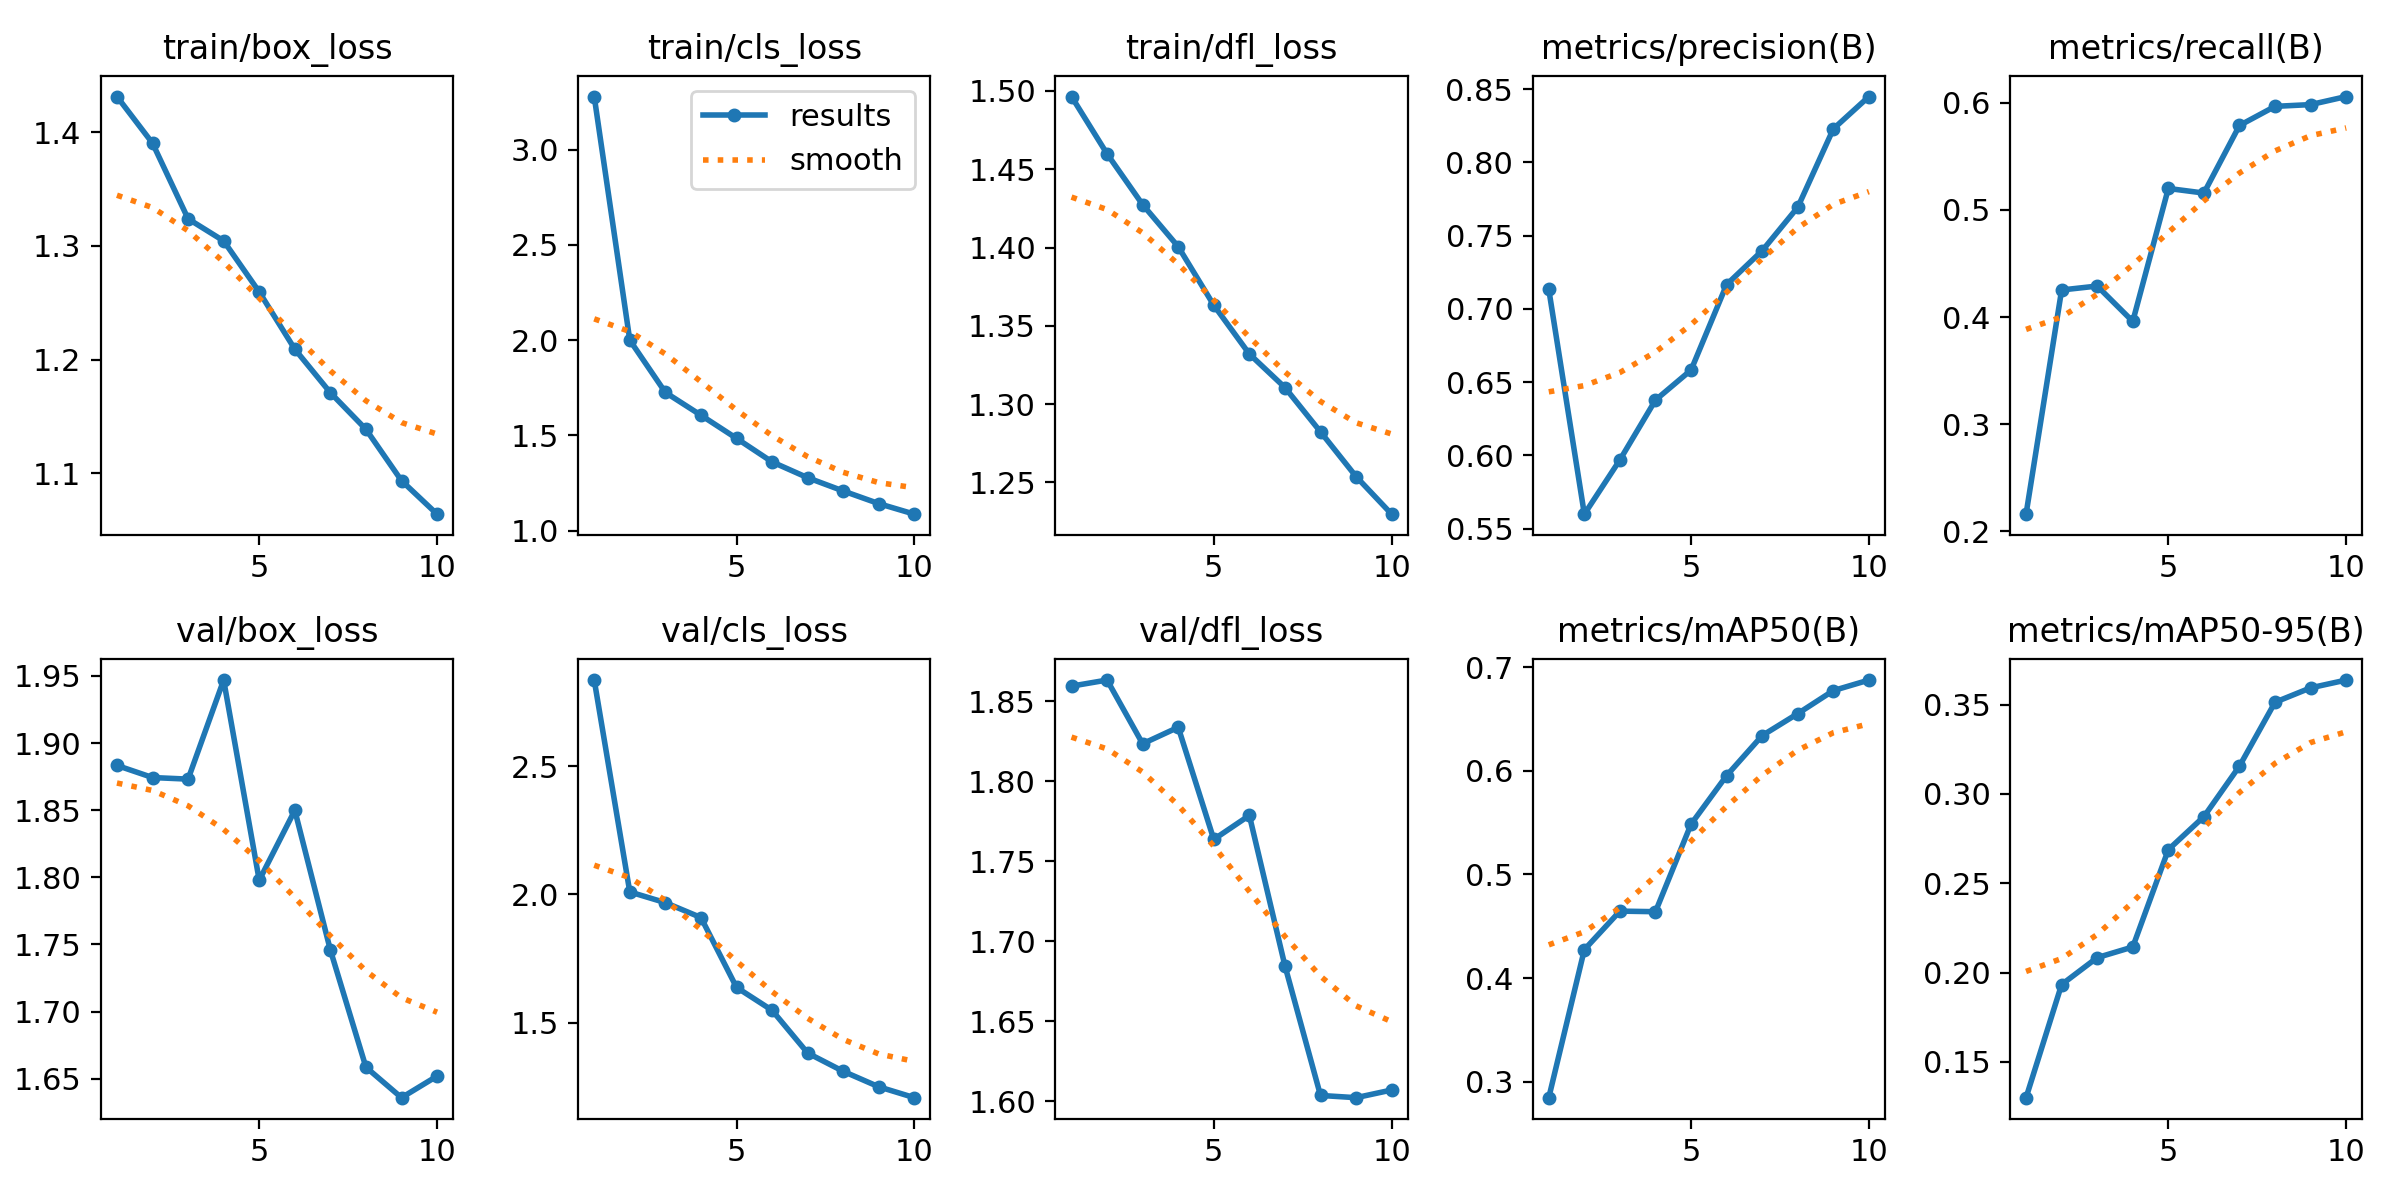

In [21]:
Image(filename=f'/content/runs/detect/train/results.png', width=900)

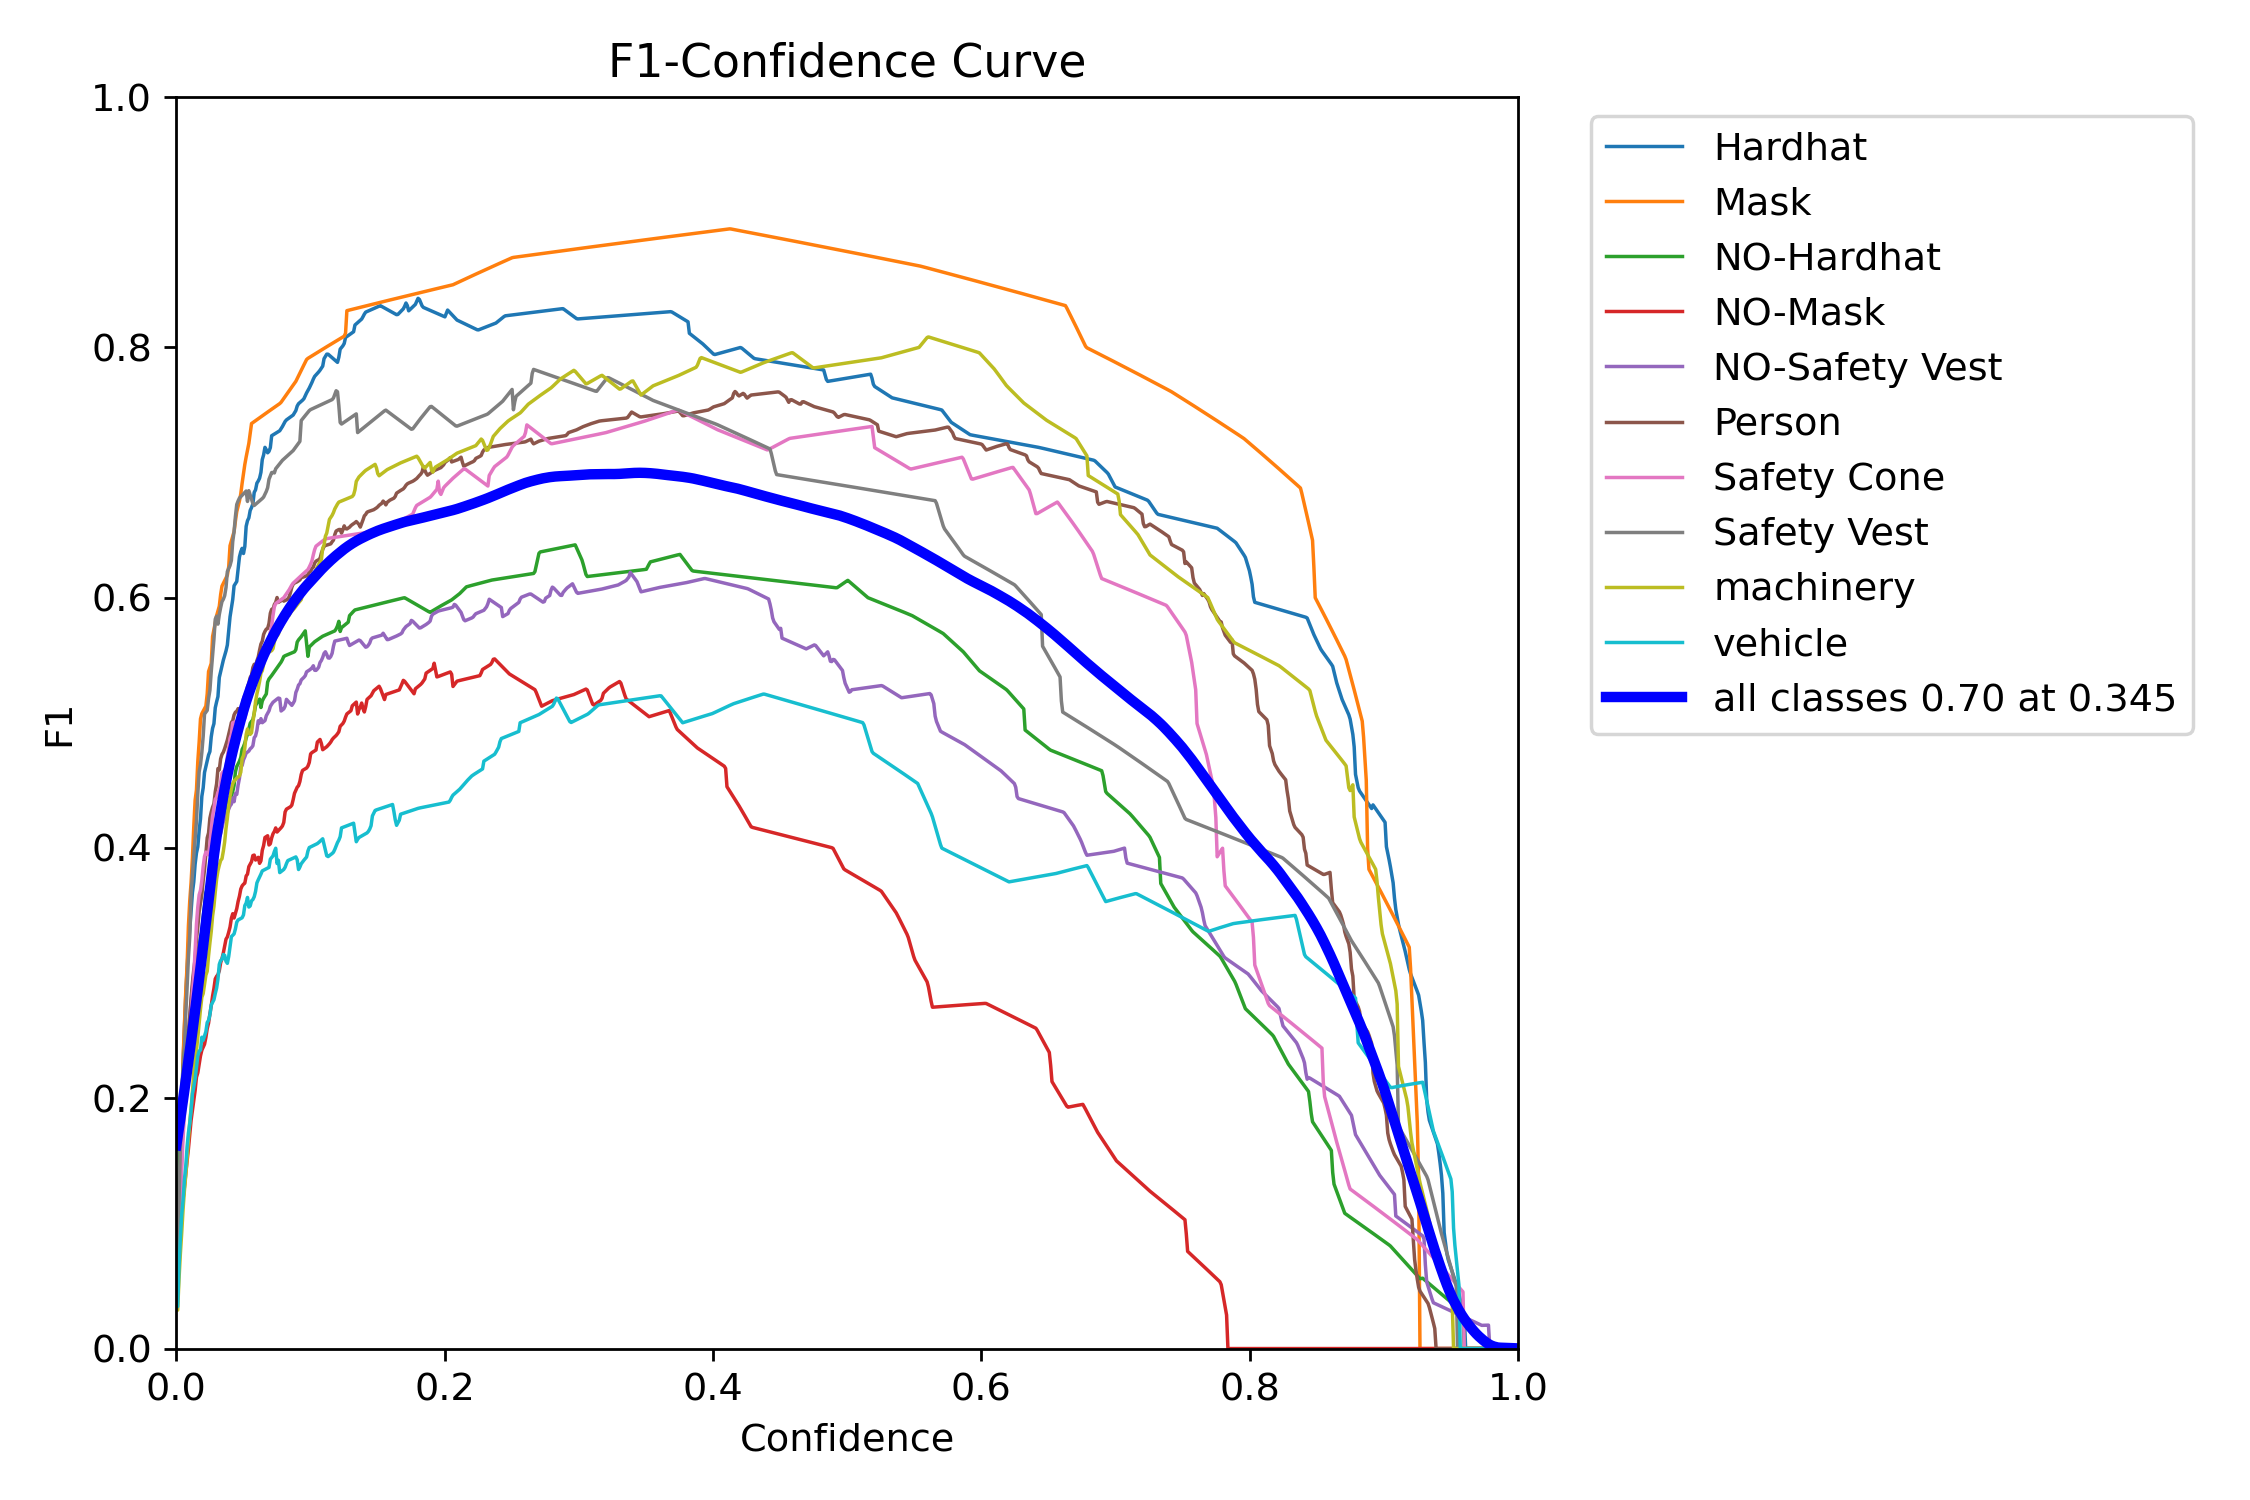

In [12]:
Image(filename=f'/content/runs/detect/train2/F1_curve.png', width=900)

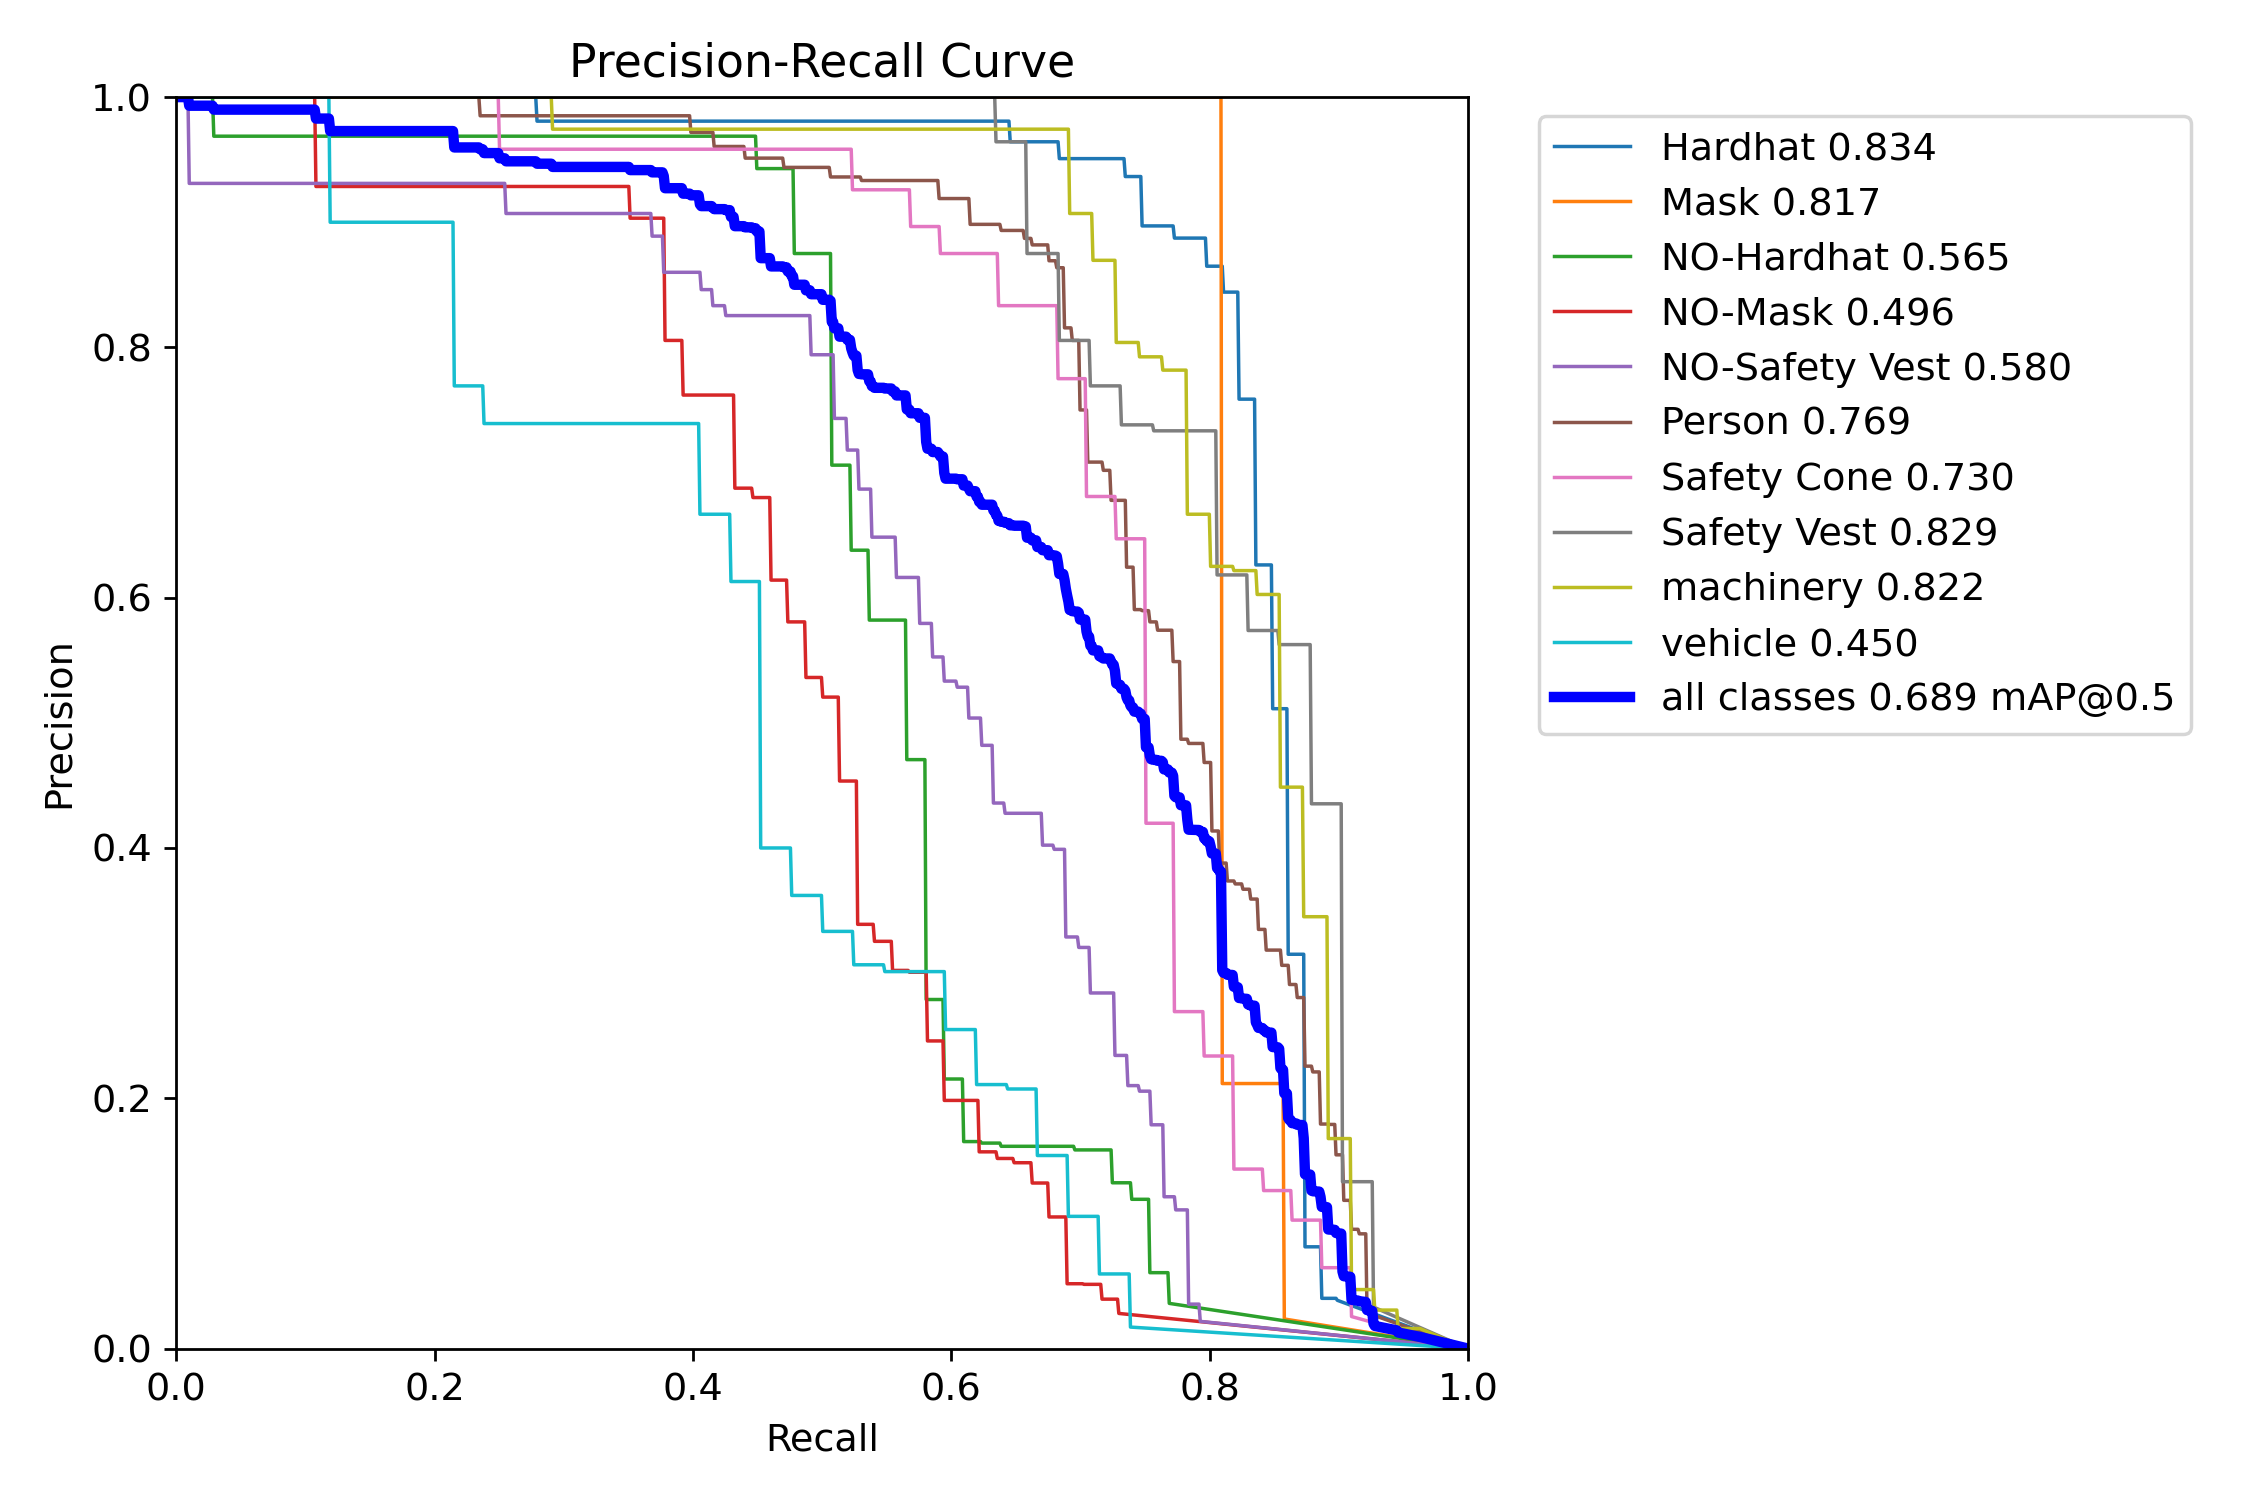

In [13]:
Image(filename=f'/content/runs/detect/train2/PR_curve.png', width=900)

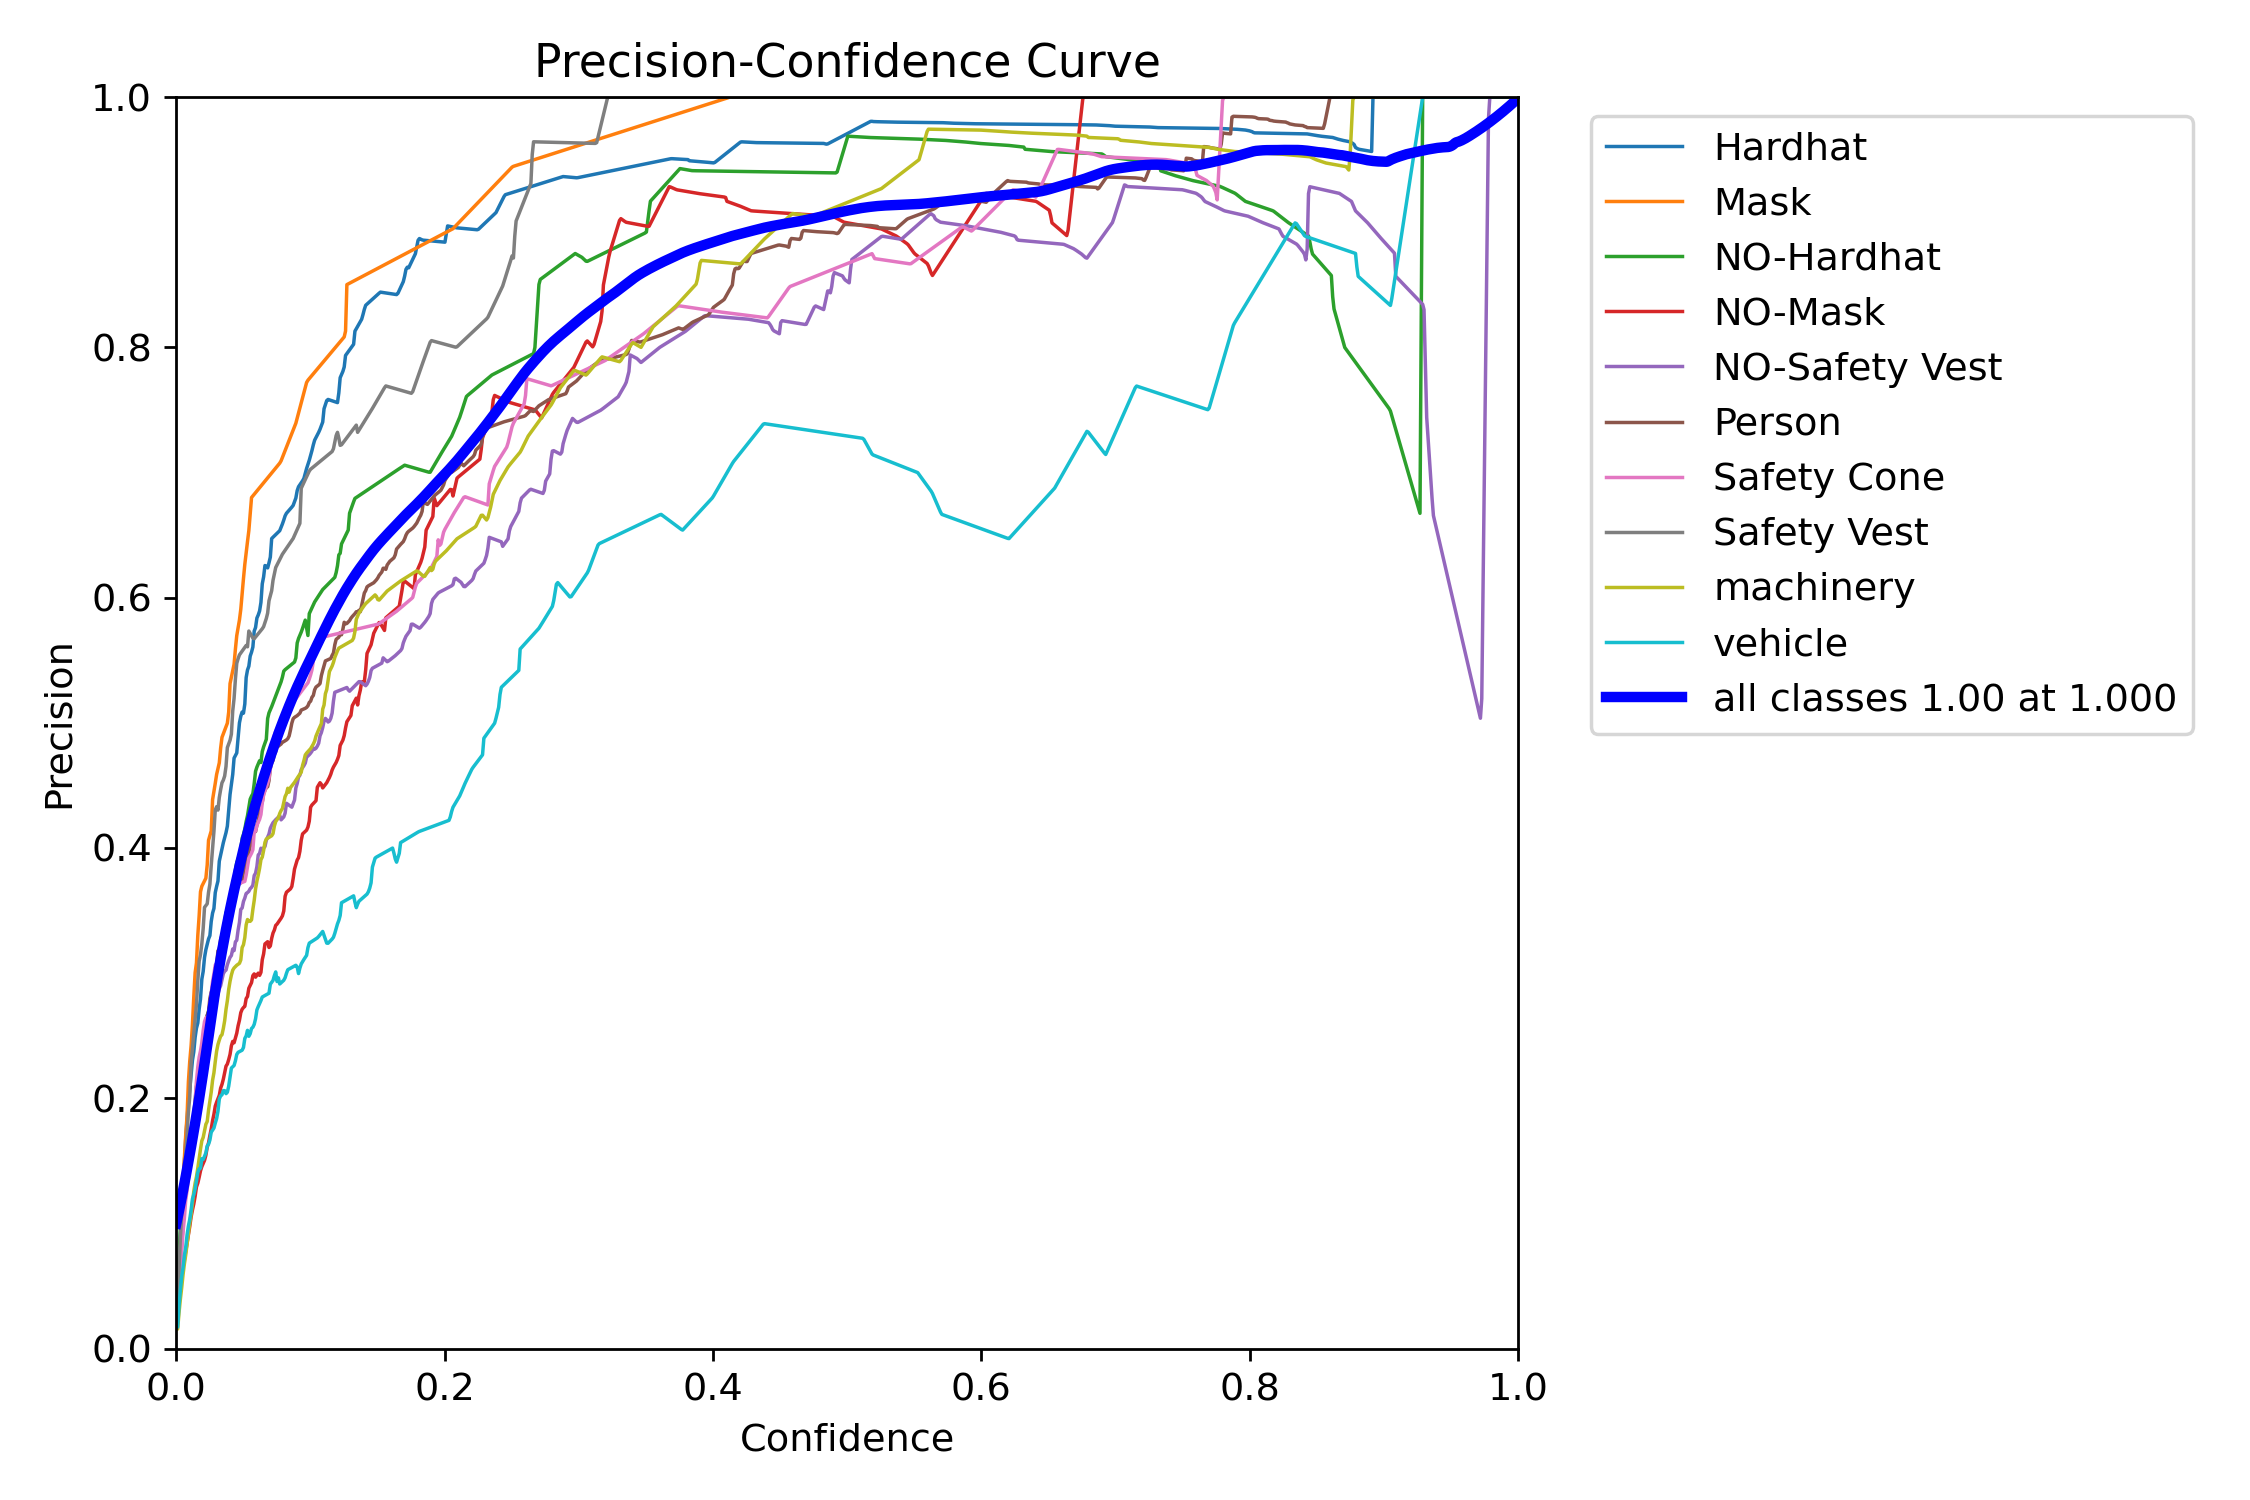

In [14]:
Image(filename=f'/content/runs/detect/train2/P_curve.png', width=900)

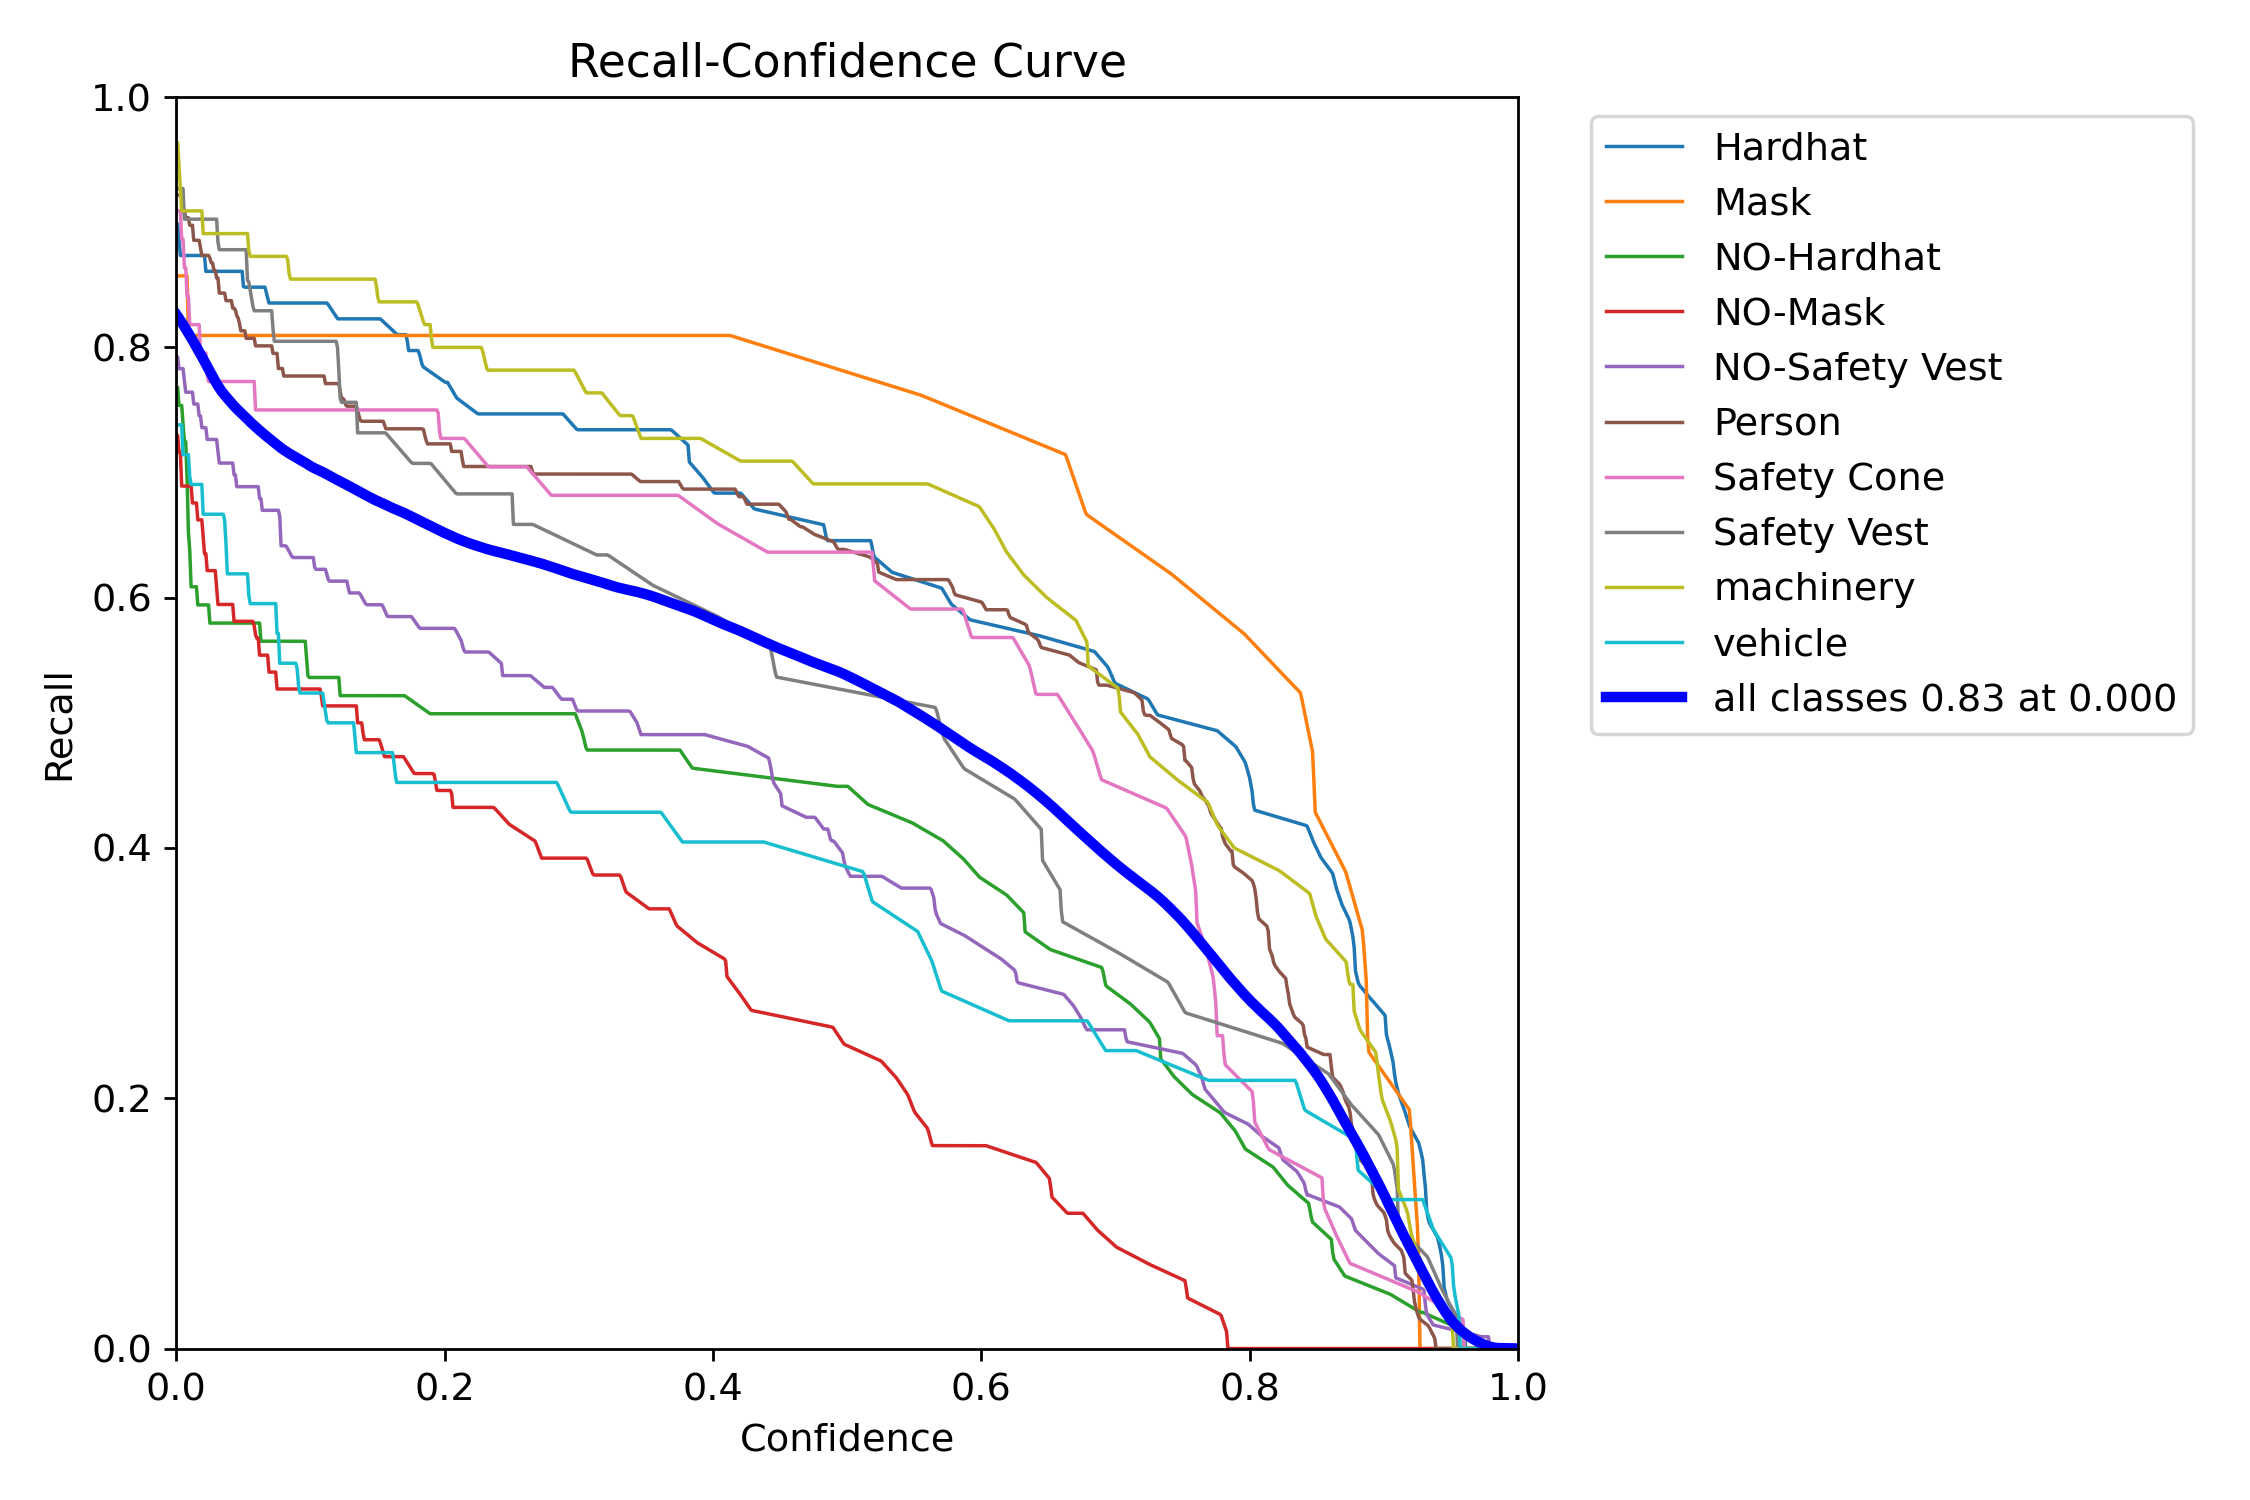

In [15]:
Image(filename=f'/content/runs/detect/train2/R_curve.png', width=900)

# 😎 Inference on test data


---
We will pick randomly 15 images from the test dataset and visualize them to evaluate the results.


In [19]:
detection_results = model.predict(source=os.path.join(INPUT_DIR, 'test/images'), save=True)


image 1/82 /content/Construction-Site-Safety-28/test/images/-4405-_png_jpg.rf.82b5c10b2acd1cfaa24259ada8e599fe.jpg: 640x640 (no detections), 29.5ms
image 2/82 /content/Construction-Site-Safety-28/test/images/000005_jpg.rf.96e9379ccae638140c4a90fc4b700a2b.jpg: 640x640 2 Hardhats, 1 NO-Mask, 1 Person, 17.6ms
image 3/82 /content/Construction-Site-Safety-28/test/images/002551_jpg.rf.ce4b9f934161faa72c80dc6898d37b2d.jpg: 640x640 3 Hardhats, 1 NO-Mask, 4 NO-Safety Vests, 3 Persons, 19.7ms
image 4/82 /content/Construction-Site-Safety-28/test/images/003357_jpg.rf.9867f91e88089bb68dc95947d5116d14.jpg: 640x640 1 Hardhat, 3 NO-Masks, 2 Persons, 1 Safety Cone, 1 vehicle, 17.6ms
image 5/82 /content/Construction-Site-Safety-28/test/images/004063_jpg.rf.1b7cdc4035bcb24ef69b8798b444053e.jpg: 640x640 5 Hardhats, 4 NO-Safety Vests, 8 Persons, 2 Safety Vests, 17.2ms
image 6/82 /content/Construction-Site-Safety-28/test/images/004763_jpg.rf.46484e6ca73caeaa9de45822cf1085a9.jpg: 640x640 3 Hardhats, 2 NO-Ma

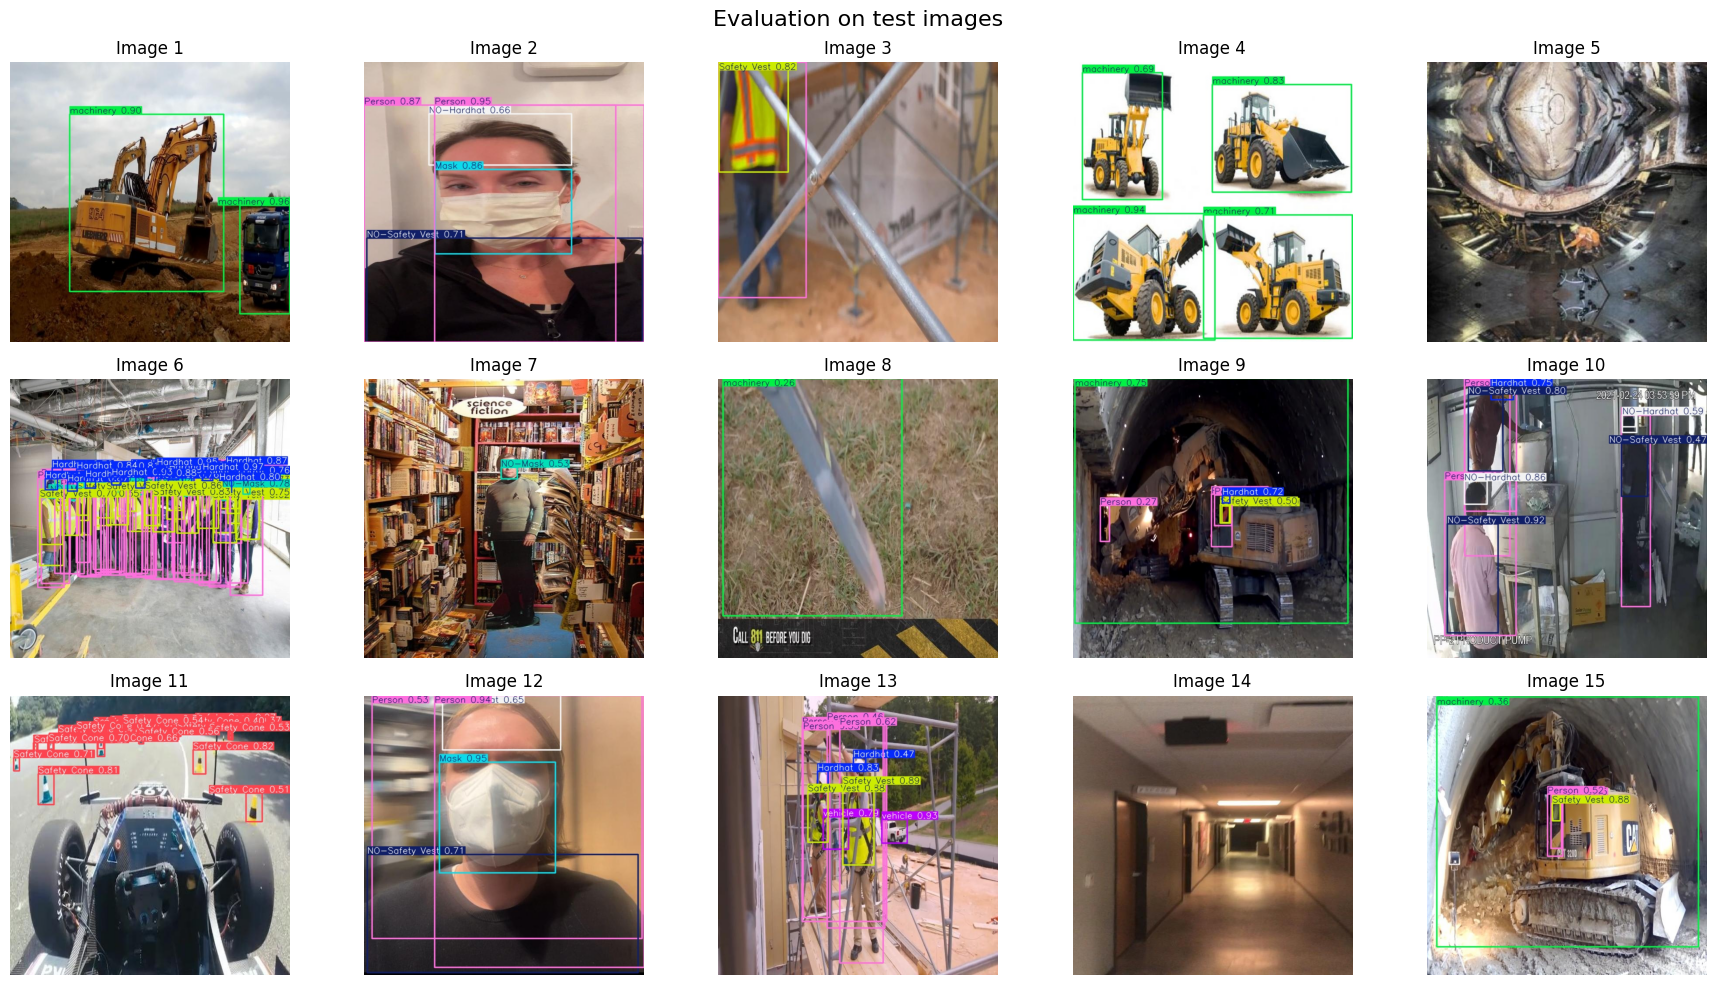

In [20]:
det_res_out_path = '/content/runs/detect/train3'

test_imgs_with_pred = glob.glob(os.path.join(det_res_out_path,'*.jpg'))

fig, axes = plt.subplots(3, 5, figsize=(18, 10))
fig.suptitle('Evaluation on test images', fontsize=16)

# Randomly select 15 images
selected_images = random.sample(test_imgs_with_pred, 15)

for i, ax in enumerate(axes.flatten()):
    image = cv2.imread(selected_images[i])
    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ax.imshow(image)
    ax.axis("off")
    ax.set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()

After evaluating the object detector, we found that the bounding boxes are generally well-aligned with the detected objects, often displaying high confidence scores that indicate reliable detections. However, a few instances exhibited lower confidence scores, pointing to potential uncertainties. Overall, the object detector performs reasonably well on the test set. Further fine-tuning or experimenting with different models could enhance performance, particularly in challenging cases.